In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
%run custom_dataset.ipynb
%run unet.ipynb

C:\anaconda3\envs\caiman\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
num_epochs = 5 #complete passes through the entire dataset
learning_rate = 0.0001 #step size at which the model weights are updated during training

In [3]:
# Define loss function and optimizer
# Binary Cross Entropy Loss for binary segmentation--> loss function used to calculate the difference between the model's predictions and the actual target values
criterion = nn.BCEWithLogitsLoss()  
#optimizer = optim.Adam(unet.parameters(), lr=learning_rate) #optimization algorithm used to update the model parameters during training in order to minimize the loss function
optimizer = optim.RMSprop(unet.parameters(), lr=learning_rate)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [5]:
# Training the UNN model
for epoch in range(num_epochs):
    unet.train()
    running_loss = 0.0
    for images, masks in data_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
    
        outputs = unet(images)
        
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    

In [16]:
#saving the trained UNN model
torch.save(unet.state_dict(), 'unet.pth')


In [2]:
#loading the trained UNN model
unet = UNet(in_channels=3, out_classes=1)  
unet.load_state_dict(torch.load('unet.pth'))
unet.eval()  # Set the model to evaluation mode

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [5]:
from PIL import Image
import cv2

image = Image.open("z_projection_gr142_resized.tif")
print("Image mode:", image.mode)  # Print the color mode (e.g., RGB, RGBA)
print("Image size:", image.size)

image_1 = cv2.imread("z_projection_gr142_resized.tif")
print("Image shape:", image_1.shape) 

Image mode: I;16B
Image size: (496, 109)
Image shape: (109, 496, 3)


In [5]:
#predictions
import torch
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((109, 496)),  # Resize input image to match model's input size
    transforms.ToTensor(),
])

image = Image.open('z_projection_gr142_rgb.tif')
input_tensor = transform(image).unsqueeze(0)  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)

# Passing the input tensor through the model to get predictions
with torch.no_grad():
    output_mask = unet(input_tensor)



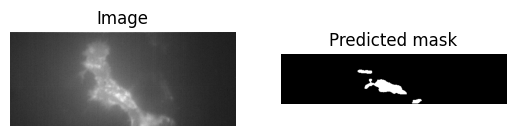

In [6]:
import matplotlib.pyplot as plt
output_mask_np = output_mask.squeeze().cpu().numpy()
output_mask_inverted = 256 - output_mask_np

threshold = 255
output_mask_thresholded = (output_mask_inverted > threshold) * 255

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[0].axis('off') 
axs[0].set_title('Image')

axs[1].imshow(output_mask_thresholded, cmap = 'binary')
axs[1].axis('off') 
axs[1].set_title('Predicted mask')

plt.show()

#plt.figure()
#plt.imshow(output_mask_inverted, cmap='binary')  
#plt.axis('off')  


In [8]:
from PIL import Image
import os
mask_path = 'C:/Users/safia/OneDrive/Desktop'

In [9]:
output_image = Image.fromarray(output_mask_thresholded)
output_image.save(os.path.join(mask_path, 'bad_mask_actual.tif'))